# Selling a used car: Timing and Price

## Business Understanding

Nowadays cars have been a necessity to a family. People buy a car, drive it for several years and sold it for a new one or get it totaled eventually. If you want to sell a used car, you are on the entrance of the used car market. You may clean your car, ask specialists to make a valuation and sell it online or not.

Before the owner ready to sold a used car, a fair price is most important to both the seller and buyer. Also, I have interested in 3 questions: 
> 1. Timing: When do people sell a car?
> 2. Price Valuation: Should the valuation made by specialists be a fair price?
> 3. Price Predication: How do we estimate the valuation of a car without the help of specialists?

## Data Understanding
To answer those questions above, a used car trading deal dataset is needed. The dataset should contain `basic information of cars`,`valuations of cars` and `final trading price`.

Fortunately, we can learn from market deals to find some insights about selling a car. Recently a dataset named “Used Car Auction Prices” on Kaggle has provided that information. This dataset which was scraped from the outside internet sources contains 559k deals in 2014–2015. Features of the dataset include model, interior, color, vin, model year, mmr and selling price.

### Take a Look at the Dataset

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,accuracy_score
from sklearn.ensemble import RandomForestRegressor
import optuna
import lightgbm as lgb  

In [2]:
df = pd.read_csv('datasets/project_car_prices.zip',error_bad_lines=False,warn_bad_lines=True)

b'Skipping line 408163: expected 16 fields, saw 17\nSkipping line 417837: expected 16 fields, saw 17\nSkipping line 421291: expected 16 fields, saw 17\nSkipping line 424163: expected 16 fields, saw 17\n'
b'Skipping line 427042: expected 16 fields, saw 17\nSkipping line 427045: expected 16 fields, saw 17\nSkipping line 434426: expected 16 fields, saw 17\nSkipping line 444503: expected 16 fields, saw 17\nSkipping line 453796: expected 16 fields, saw 17\n'
b'Skipping line 461599: expected 16 fields, saw 17\nSkipping line 461614: expected 16 fields, saw 17\n'
b'Skipping line 492486: expected 16 fields, saw 17\nSkipping line 497010: expected 16 fields, saw 17\nSkipping line 497013: expected 16 fields, saw 17\nSkipping line 499085: expected 16 fields, saw 17\nSkipping line 501457: expected 16 fields, saw 17\nSkipping line 505301: expected 16 fields, saw 17\nSkipping line 505308: expected 16 fields, saw 17\nSkipping line 520463: expected 16 fields, saw 17\n'
b'Skipping line 528998: expected 1

In [3]:
df.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


In [4]:
df.shape

(558811, 16)

The dataset has 559k rows with 16 features.

### Meaning of Special Features

Most of the features are easy to understand, but there are some special.

#### vin: Vehicle identification number

The first special feature is `vin`. From `wikipedia`, `vin` means ***Vehicle identification number***.
> A vehicle identification number (VIN) (also called a chassis number or frame number) is a unique code, including a serial number, used by the automotive industry to identify individual motor vehicles, towed vehicles, motorcycles, scooters and mopeds, as defined in ISO 3779 (content and structure) and ISO 4030 (location and attachment).

>  A `vin` has 17 letters. Components of `vin` are `World manufacturer identifier`(1-3),`Vehicle descriptor section`(4-9) and	`Vehicle identifier section`(10-17).

> Country or region codes can be distinguished by the first 2 letters of `World manufacturer identifier`.

> https://en.wikipedia.org/wiki/Vehicle_identification_number#Components

So we can **add a feature `made_country` with the first 2 letters of `vin`**.


We can check the info of a vin by https://driving-tests.org/vin-decoder/. If we query the first vin of the data `5xyktca69fg566472`,we can get a result like :

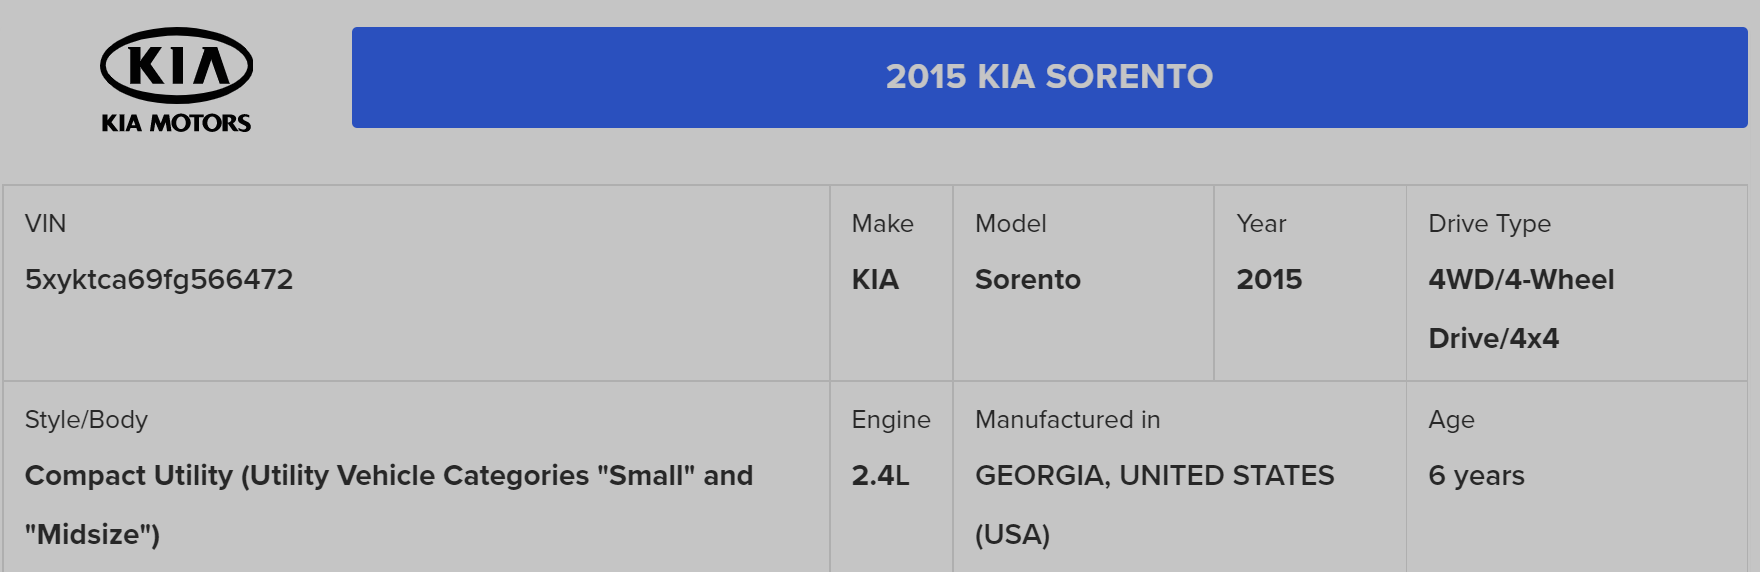

#### mmr: Manheim Market Report

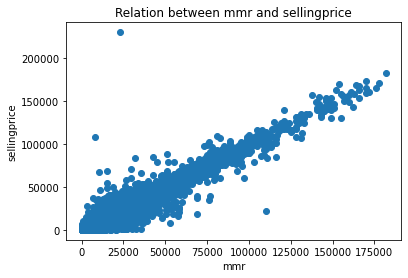

In [5]:
plt.scatter(df['mmr'],df['sellingprice'])
plt.title('Relation between mmr and sellingprice')
plt.xlabel('mmr')
plt.ylabel('sellingprice')
plt.show()

What really intersting is that `mmr` and `sellingprice` are so highly correlated. I did not find an explanation in `wikipedia`. But with Google I found this https://www.autoauctionmall.com/learning-center/what-does-mmr-mean/. 
> MMR in the car business stands for Manheim Market Report, an indicator of wholesale prices.

> Manheim is a company established in 1945 as a car auction company. It has grown to a very reputable company and its MMR is a baseline tool for wholesale car price determination. They base their price calculations on over 10 million transaction over the past 13-month period to .

I think that explained  why `mmr` and `sellingprice` are so close to each other in the figure. `mmr` is a valuation made by the Manheim company.The company should make full use of all the infomation of car like `model`,`odometer` and so on.

So it is **not** a good idea to take `mmr` as a explanatory feature.

#### odometer: measuring the distance traveled by a vehicle

In [6]:
df['odometer'].mean()

68323.19579679874

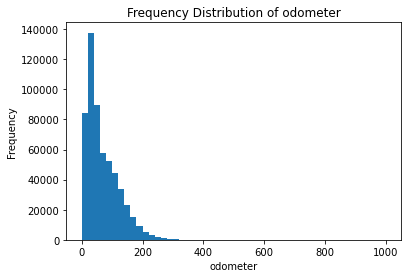

In [7]:
plt.hist(df['odometer']/1000,bins=50)
plt.title('Frequency Distribution of odometer')
plt.xlabel('odometer')
plt.ylabel('Frequency')
plt.show()

`odometer` means:
> An odometer or odograph is an instrument used for measuring the distance traveled by a vehicle, such as a bicycle or car. The device may be electronic, mechanical, or a combination of the two (electromechanical). The noun derives from ancient Greek ὁδόμετρον, hodómetron, from ὁδός, hodós ("path" or "gateway") and μέτρον, métron ("measure"). Early forms of the odometer existed in the ancient Greco-Roman world as well as in ancient China. In countries using Imperial units or US customary units it is sometimes called a mileometer or milometer, the former name especially being prevalent in the United Kingdom and among members of the Commonwealth.
> https://en.wikipedia.org/wiki/Odometer

From the figure above,the unit of measurement may be `kilometers`. If that is true, the mean odometer of used cars is 68000 kilometers. And most of them are within 200000 kilometers.

#### year: vehicle's model year

After checking several vins, the `year` equals vehicle's model year.

In [8]:
# change `mmr` to `valuation` and `year` to `model_year` for better understand
df=df.rename(columns={'mmr':'valuation','year':'model_year'})

##  Data Preparation

### Overview of the Data


In [9]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_ratio','dtypes','uique_counts'])\
    .sort_values(by=['null_ratio'],axis=1,ascending=False)

,transmission,body,condition,trim,model,make,color,interior,odometer,model_year,vin,state,seller,valuation,sellingprice,saledate
null_ratio,0.11695,0.023613,0.021106,0.01906,0.018609,0.018434,0.00134,0.00134,0.000168,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,object,object,float64,object,object,object,object,object,float64,int64,object,object,object,int64,int64,object
uique_counts,2,86,41,1975,973,96,20,17,172277,34,550296,38,14264,1101,1887,3745


In [10]:
df.shape

(558811, 16)

### Handle Missing Values
`transmission` has the most ratio of `NULL` 12%. The fraction of values missing in other columns is less than 3%.Since the whole share of `NULL` feature is small. We can fill NA with 'unknown' with in `transmission` feature and remove NA in all other columns since the fraction is small.


In [11]:
df_clean = df.copy()
df_clean['transmission']=df_clean['transmission'].fillna('unknown')
df_clean=df_clean.dropna(axis=0)

### Handle Duplicated Rows
The dataset has no duplicated rows

In [12]:
df_clean.duplicated().sum()

0

### Add Feature 
From the chapter `vin: Vehicle identification number`
> Country or region codes can be distinguished by the first 2 letters of World manufacturer identifier.
>
> So we can **add a feature `made_country` with the first 2 letters of `vin`**.

In [13]:
df_clean['made_country']=df_clean['vin'].map(lambda x:x[:2])

To get a deeper insight of trading datetime, it may be useful to extract datetime attributes of `saledate` like `year`,`quarter` etc.

In [14]:

df_clean['sale_datetime'] = pd.to_datetime(df_clean['saledate'],utc=True)


In [15]:
df_clean['sale_year']=df_clean['sale_datetime'].dt.year.astype('int32')
df_clean['sale_quarter']=df_clean['sale_datetime'].dt.quarter.astype('int8')
df_clean['sale_month']=df_clean['sale_datetime'].dt.month.astype('int8')
df_clean['sale_dayofweek']=df_clean['sale_datetime'].dt.day_of_week.astype('int8')
df_clean['sale_day']=df_clean['sale_datetime'].dt.day.astype('int8')
df_clean['sale_hour']= df_clean['sale_datetime'].dt.hour.astype('int8')

We have `model_year` and `sale_year`, so we can extract a feature `used_year` which indicates how many years the car had been used.

In [16]:
df_clean['used_year']=df_clean['sale_year']-df_clean['model_year']

To check the difference between `sellingprice` and `valuation`, we can add a column `sale_delta`.

In [17]:
df_clean['sale_delta'] = df_clean['sellingprice']-df_clean['valuation']

### Data Lowercase
Transform `body` feature into lowercase.

In [18]:
df_clean['body']=df_clean['body'].map(lambda x:str(x).lower())

### Data Cleaned Overview

In [19]:
pd.DataFrame([df_clean.isnull().mean(),df_clean.dtypes,df_clean.nunique()],index=['null_ratio','dtypes','uique_counts'])\
    .sort_values(by=['null_ratio'],axis=1,ascending=False)

,model_year,make,used_year,sale_hour,sale_day,sale_dayofweek,sale_month,sale_quarter,sale_year,sale_datetime,...,color,odometer,condition,state,vin,transmission,body,trim,model,sale_delta
null_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,int64,object,int64,int8,int8,int8,int8,int8,int32,"datetime64[ns, UTC]",...,object,float64,float64,object,object,object,object,object,object,int64
uique_counts,26,53,27,21,31,6,8,4,2,3687,...,20,166557,41,38,525650,3,45,1523,772,1428


In [20]:
df_clean.shape

(533660, 26)

The dataset has no missing value now, feature number increases from 16 to 26 and rows decreses from 559k to 534k. 

### 1. Timing: When do people sell a car?

We can analyze that question  from `odometer` ,`condition` and `used_year` features.

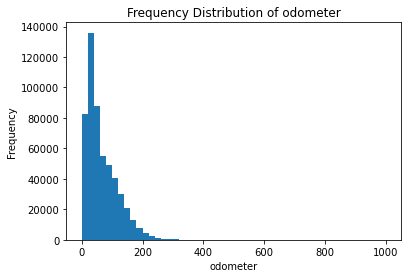

In [21]:
plt.hist(df_clean['odometer']/1000,bins=50)
plt.title('Frequency Distribution of odometer')
plt.xlabel('odometer')
plt.ylabel('Frequency')
plt.show()

In [22]:
df_clean['odometer'].quantile([.25, .5, .75,.90,.98])

0.25     27746.75
0.50     50145.00
0.75     95813.00
0.90    139065.00
0.98    198764.82
Name: odometer, dtype: float64

From the odometer we can find that most of cars were sold with odometer less than 96,000km (75% quantile), 90% quantile 140,000km and 98% quantile 200,000km.

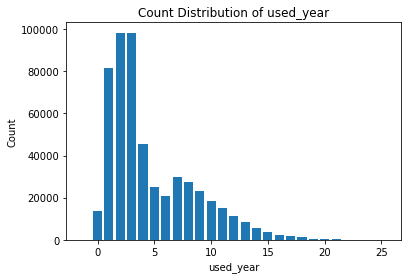

In [23]:
used_year_count =df_clean['used_year'].value_counts()
plt.bar(used_year_count.index,used_year_count.values)
plt.title('Count Distribution of used_year')
plt.xlabel('used_year')
plt.ylabel('Count')
plt.show()

In [24]:
df_clean['used_year'].quantile([.25, .5, .75,0.9,.98])

0.25     2.0
0.50     3.0
0.75     7.0
0.90    10.0
0.98    15.0
Name: used_year, dtype: float64

Most of the cars has used less than 7 years (75% quantile), 90% quantile 10 years when were sold. From 7 years the longer the car used, the number of deals is less which means the harder the car can be sold.

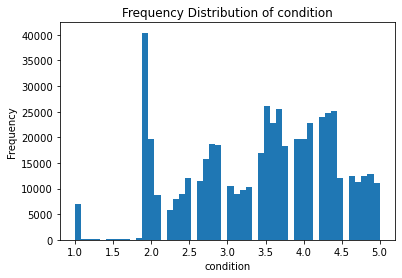

In [25]:
plt.hist(df_clean['condition'],bins=50)
plt.title('Frequency Distribution of condition')
plt.xlabel('condition')
plt.ylabel('Frequency')
plt.show()

This figure shows an interesting result that the condition distribution did not affect the cars sold only if the condition was above 2.0

To sum up odometer, used year and condition, it’s better to sell a car when travels below 96,000km as earlier as possible in 10 years, regardless of condition.

### 2. Price Valuation: Should the valuation made by specialists be a fair price?

It's a good idea to analyze the relation between `sellingprice` and `valuation`. And I made a LinearRegression between them, and valuation can explain 97% of the sellingprice.

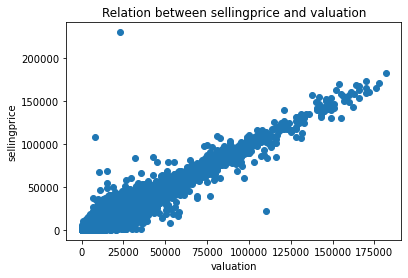

In [26]:
plt.scatter(df_clean['valuation'],df_clean['sellingprice'])
plt.title('Relation between sellingprice and valuation')
plt.xlabel('valuation')
plt.ylabel('sellingprice')
plt.show()

In [27]:
# simple LinearRegression between `sellingprice` and `valuation`
Xa=df['valuation'].values.reshape(-1, 1) 
ya=df['sellingprice'].values
linear_clfa = LinearRegression()
linear_clfa.fit(Xa,ya)
print(linear_clfa.score(Xa,ya))

0.9675352890180333


To go deeper, let's analyze column `sale_delta` which is the difference  between `sellingprice` and `valuation`

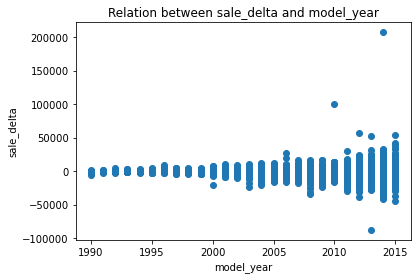

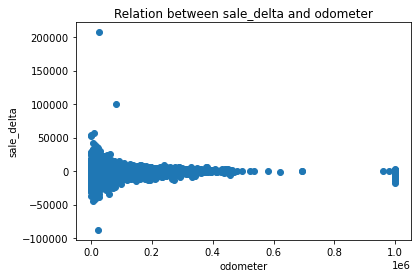

In [28]:
plt.scatter(df_clean['model_year'],df_clean['sale_delta'])
plt.title('Relation between sale_delta and model_year')
plt.xlabel('model_year')
plt.ylabel('sale_delta')
plt.show()

plt.scatter(df_clean['odometer'],df_clean['sale_delta'])
plt.title('Relation between sale_delta and odometer')
plt.xlabel('odometer')
plt.ylabel('sale_delta')
plt.show()

The variance of `sale_delta` goes up as `model_year` increase and as `odometer` down. The more the car traveled or the longer the car used, the more accurate the prediction is.

In [29]:
df_clean['sale_delta'].mean()

-153.43534272757935

So, should a seller choose to believe valuation? Yes, and valuation can be a good predict to the final sellingprice only if seller has access to valuation made by specialists.

`valuation` is  slightly higher than the `sellingprice` on average (153 USD per car).

## Data Modeling
### 3. Price Predication: How do we estimate the valuation of a car without the help of specialists?
To answer the last question `How do we estimate the valuation of a car without the help of specialists?`, a machine learning model is in need.

### feature selection

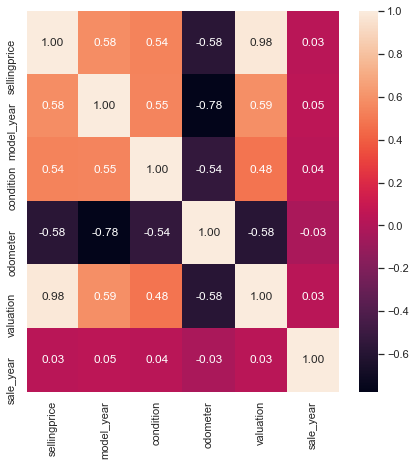

In [30]:
heatmap_col=['sellingprice','model_year','condition','odometer','valuation','sale_year']
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(df_clean[heatmap_col].corr(), annot=True, fmt=".2f");

In [31]:
# choose features and filter `valuation` out since the time we try to predict wihout the help of specialists
choosed_cols = ['model_year','condition','odometer','sellingprice',
                'make','model','trim','transmission','state','color','interior',
                'sale_dayofweek','sale_month','made_country','body']

In [32]:
df_feature_selected=df_clean[choosed_cols]

In [33]:
pd.DataFrame([df_feature_selected.isnull().mean(),df_feature_selected.dtypes,df_feature_selected.nunique()],index=['null_ratio','dtypes','uique_counts'])\
    .sort_values(by=['null_ratio'],axis=1,ascending=False)

,model_year,condition,odometer,sellingprice,make,model,trim,transmission,state,color,interior,sale_dayofweek,sale_month,made_country,body
null_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,int64,float64,float64,int64,object,object,object,object,object,object,object,int8,int8,object,object
uique_counts,26,41,166557,1852,53,772,1523,3,38,20,17,6,8,101,45


Cleaned dataset `df_clean` has no missing values now because missing values has been handled in `Data Preparation`.  And categorical variables don't need to consider set `dummy_na=True` when the model handles `object` columns. 

In [34]:
# One-Hot Encode 
cat_cols = df_feature_selected.select_dtypes(include=['object']).columns
ff_1 = pd.get_dummies(df_feature_selected[cat_cols],dummy_na=False,prefix_sep='_',drop_first=True)
ff_2 = df_feature_selected.drop(cat_cols,axis=1)

df_model = ff_1.merge(ff_2,left_index=True,right_index=True)

In [36]:
X_df = df_model.drop(['sellingprice'],axis=1)
y_df = df_model['sellingprice']

In [37]:
# tuning wiht opunta
def objective(trial):
    """
    optimize objective fucntion of `optuna`
    Args:
        trial: int, trial number times.
    Retrun:
        score: float,return the fit score after each trail of tuning.
    """
    data,target = X_df.values,y_df.values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    param = {
        "n_estimators":trial.suggest_int("n_estimators",20,200,log=True),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    score = r2_score(valid_y, pred_labels)
    return score


In [38]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-08-20 13:16:52,638] A new study created in memory with name: no-name-0fd61550-5c4a-4a6f-861d-cf4fc68feb78
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3469
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1570
[LightGBM] [Info] Start training from score 13870.755447


[I 2021-08-20 13:19:19,038] Trial 0 finished with value: 0.9346000418757955 and parameters: {'n_estimators': 172}. Best is trial 0 with value: 0.9346000418757955.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3477
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1574
[LightGBM] [Info] Start training from score 13857.306670


[I 2021-08-20 13:21:37,385] Trial 1 finished with value: 0.801838170364073 and parameters: {'n_estimators': 27}. Best is trial 0 with value: 0.9346000418757955.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3479
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1575
[LightGBM] [Info] Start training from score 13861.872948


[I 2021-08-20 13:23:50,700] Trial 2 finished with value: 0.80102290208735 and parameters: {'n_estimators': 27}. Best is trial 0 with value: 0.9346000418757955.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1569
[LightGBM] [Info] Start training from score 13853.905600


[I 2021-08-20 13:25:50,913] Trial 3 finished with value: 0.9355795097146308 and parameters: {'n_estimators': 188}. Best is trial 3 with value: 0.9355795097146308.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3463
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1567
[LightGBM] [Info] Start training from score 13844.970278


[I 2021-08-20 13:27:50,466] Trial 4 finished with value: 0.7471497245269361 and parameters: {'n_estimators': 20}. Best is trial 3 with value: 0.9355795097146308.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3477
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1574
[LightGBM] [Info] Start training from score 13870.741671


[I 2021-08-20 13:29:49,638] Trial 5 finished with value: 0.7761717036998129 and parameters: {'n_estimators': 23}. Best is trial 3 with value: 0.9355795097146308.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3483
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1577
[LightGBM] [Info] Start training from score 13859.734075


[I 2021-08-20 13:31:45,807] Trial 6 finished with value: 0.8551422024429883 and parameters: {'n_estimators': 42}. Best is trial 3 with value: 0.9355795097146308.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1569
[LightGBM] [Info] Start training from score 13864.420517


[I 2021-08-20 13:33:45,224] Trial 7 finished with value: 0.9134930722594681 and parameters: {'n_estimators': 108}. Best is trial 3 with value: 0.9355795097146308.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3459
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1565
[LightGBM] [Info] Start training from score 13859.930313


[I 2021-08-20 13:35:50,813] Trial 8 finished with value: 0.9288483514672208 and parameters: {'n_estimators': 144}. Best is trial 3 with value: 0.9355795097146308.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3499
[LightGBM] [Info] Number of data points in the train set: 400245, number of used features: 1585
[LightGBM] [Info] Start training from score 13861.834814


[I 2021-08-20 13:37:48,801] Trial 9 finished with value: 0.7519842725840169 and parameters: {'n_estimators': 20}. Best is trial 3 with value: 0.9355795097146308.


Number of finished trials: 10
Best trial:
  Value: 0.9355795097146308
  Params: 
    n_estimators: 188


## Evaluate the Results.

In [39]:
# one of the best params the optuna computed is 198
train_x, valid_x, train_y, valid_y = train_test_split(X_df.values, y_df.values,
                                                      test_size=0.25,random_state=100)
lgb_clf = lgb.LGBMRegressor(n_estimators=198)
lgb_clf.fit(train_x,train_y)
print(lgb_clf.score(valid_x,valid_y))


0.9400510076339358


And the model can explain 94% of the sellingprice which is only slightly lower than valuation predication 97%.

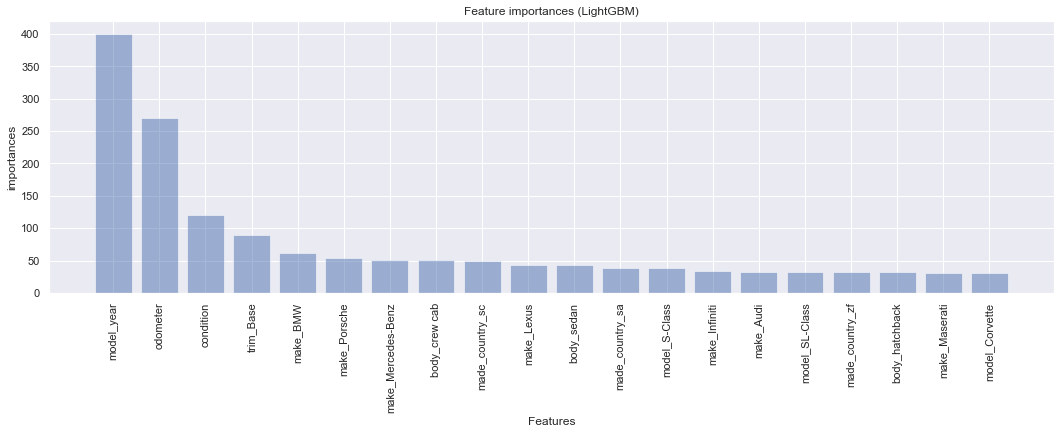

In [40]:
#inspiration by https://www.kaggle.com/aleksandradeis/airbnb-seattle-reservation-prices-analysis#Machine-Learning
headers = ["name", "score"]
values = sorted(zip(X_df, lgb_clf.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:20]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:20]

#plot feature importances
plt.figure(figsize=(18,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('importances')
plt.xlabel('Features')
plt.title('Feature importances (LightGBM)') 
plt.show()

## Conclusion

In this analysis, we tried to understand the timing when people sell a car is less than 96,000km. The valuation made by specialists is close to the final selling price. And we can make a prediction model by ourself with basic information of a used car.

Hope the predication is helpful to people who want to sell their cars!